In [ ]:
# Some imports first
import numpy as np # for storing imaging data as matrices
import matplotlib.pyplot as plt # for basic plotting
import os
import copy

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/scml-segmentation-challenge/sample_submission.csv
/kaggle/input/scml-segmentation-challenge/y_train.npy
/kaggle/input/scml-segmentation-challenge/X_test.npy
/kaggle/input/scml-segmentation-challenge/X_train.npy


In [ ]:
X_train = np.load("/kaggle/input/scml-segmentation-challenge/X_train.npy")
y_train = np.load("/kaggle/input/scml-segmentation-challenge/y_train.npy")
X_test = np.load("/kaggle/input/scml-segmentation-challenge/X_test.npy")

In [ ]:
print(f'Train images shape:{X_train.shape}')
print(f'Train masks shape:{y_train.shape}')
print(f'Test shape:{X_test.shape}')

Train images shape:(882, 512, 512)
Train masks shape:(882, 512, 512)
Test shape:(263, 512, 512)


In [ ]:
def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"

    mycmap = copy.deepcopy(cmap)
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap

#Use base cmap to create transparent
mycmap = transparent_cmap(plt.cm.Reds)

def visualise_predictions (X, y, predictions, size = 16):
    indeces = np.random.randint(0, len(X), size = size)
    plt.figure(figsize=(12, 12))

    for i, index in enumerate(indeces):
        plt.subplot(int(np.sqrt(size)), int(np.sqrt(size)), i + 1)

        index = np.random.randint(0, len(X))

        # Creating kidney masks
        kidney_mask = copy.deepcopy(y[index])
        kidney_mask[kidney_mask != 1] = 0

        # Creating tumor masks    
        tumor_mask = copy.deepcopy(y[index])
        tumor_mask[tumor_mask != 2] = 0

        # Plotting the CT scan itself
        plt.imshow(X[index], cmap = 'gray') 

        # Potting predictions
        plt.contourf(range(0,512), range(0,512), np.reshape(predictions[index], (512, 512)), 15, cmap = mycmap)
        plt.contour(predictions[index] > 0.5, [0.5], linewidths=1.5, colors='white')

        # Adding countours
        plt.contour(kidney_mask, linewidths = 1, colors=['cyan'])
        plt.contour(tumor_mask, linewidths = 1, colors=['red'])

        plt.tight_layout()
        plt.axis('off')

    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    return None

Let's visualise several random training examples along with corresponding masks (cyan - kidney, red - tumor). Function `visualise_predictions()` was meant to visualise predictions (not kidding), therefore it expects the array of predictions, since we do not have them yet, we will improvise :)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: No contour levels were found within the data range.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: No contour levels were found within the data range.


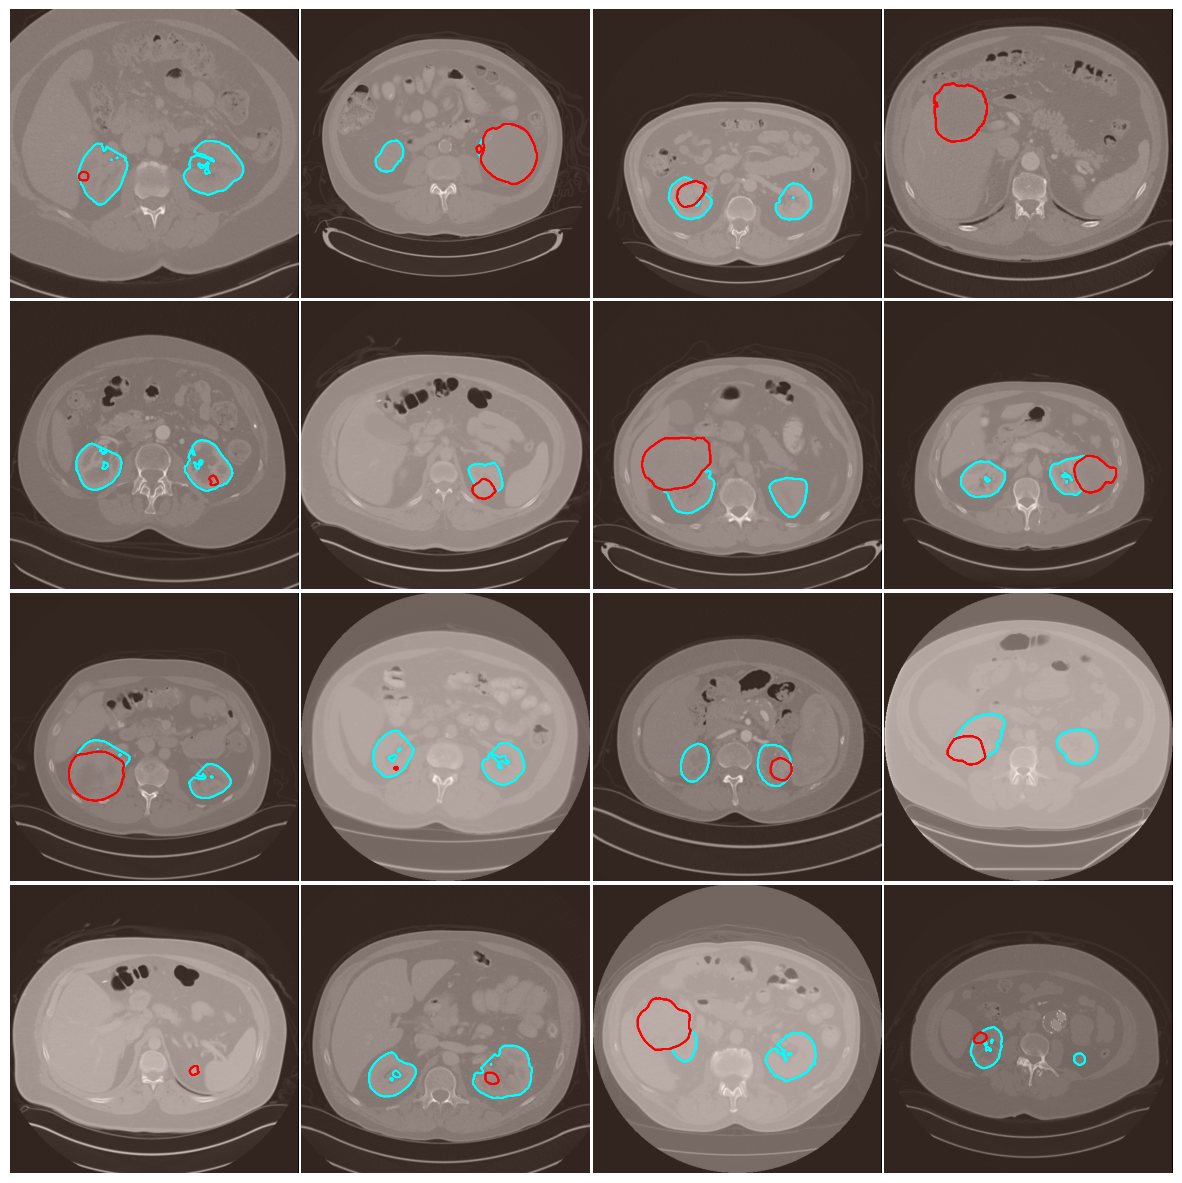

In [ ]:
# only works with size = 4, 9, 16 :)
visualise_predictions(X = X_train, y = y_train, predictions = np.zeros_like(y_train), size = 16)

Now, let's look into test set, no contours here, therefore need to immitate masks using `np.zeros_like(X_test)`.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: No contour levels were found within the data range.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: No contour levels were found within the data range.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: No contour levels were found within the data range.


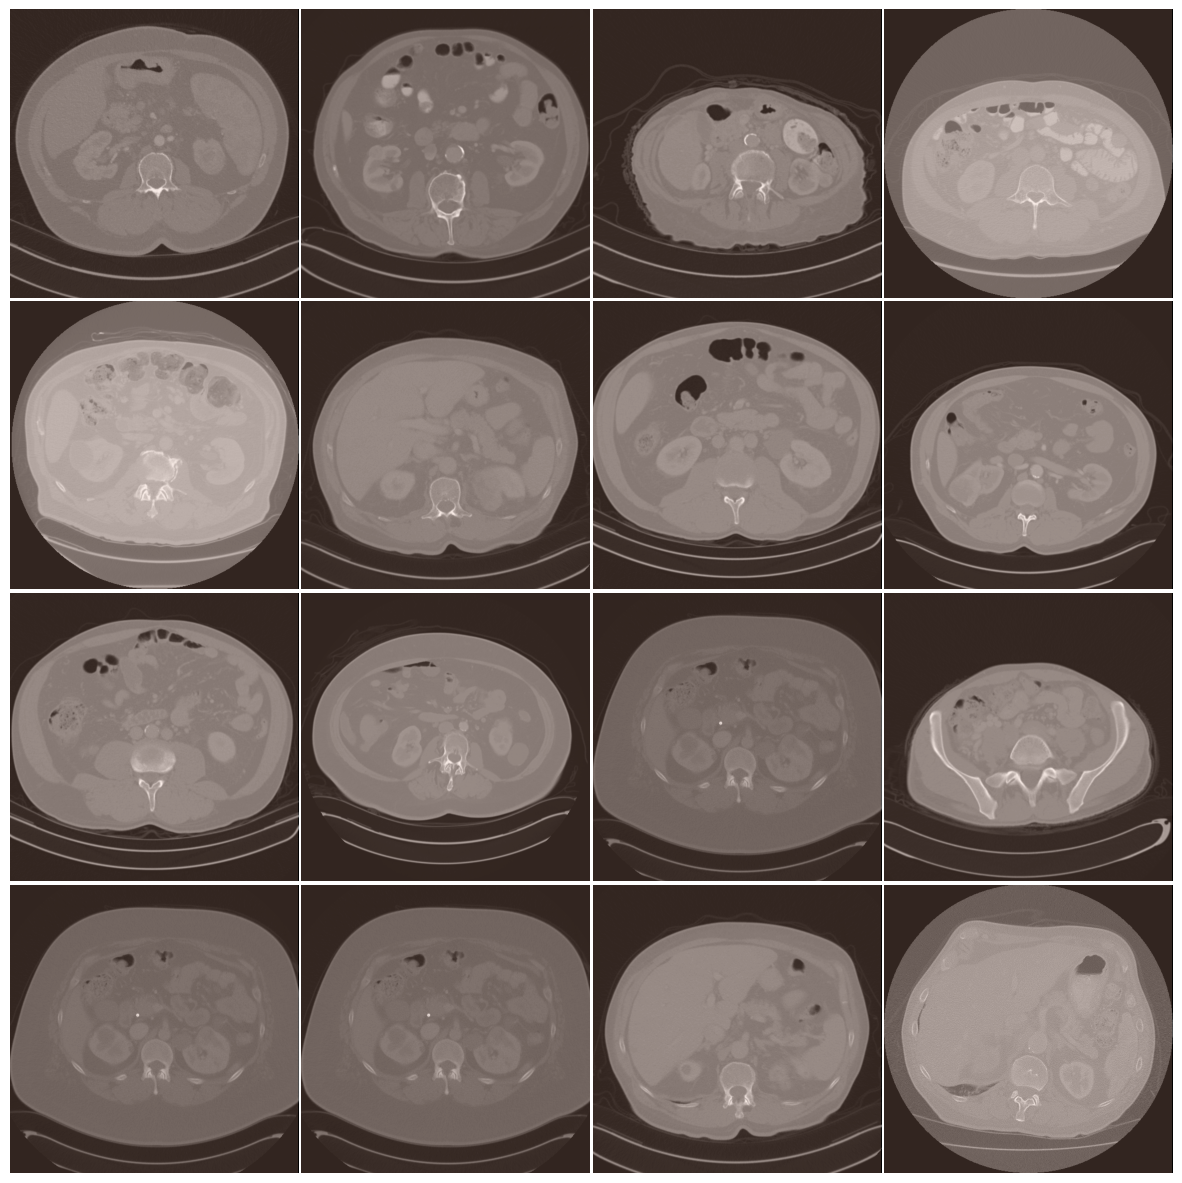

In [ ]:
visualise_predictions(X = X_test, y = np.zeros_like(X_test), predictions = np.zeros_like(X_test), size = 16)

We have provided you kidney masks (`y_train == 1`) just in case, otherwise all you care about is tumors (`y_train == 2`), therefore it might be a good idea to create a different version of the `y_train` that only contains tumors.

In [ ]:
y_train_binary = np.copy(y_train)
y_train_binary[y_train_binary == 1] = 0
y_train_binary[y_train_binary == 2] = 1

My code

New Model

Trying another model

In [ ]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 1

NUM_TEST_IMAGES = 10

In [ ]:
print(f'Train images shape:{X_train.shape}')
print(f'Train masks shape:{y_train_binary.shape}')
print(f'Test shape:{X_test.shape}')

Train images shape:(882, 512, 512)
Train masks shape:(882, 512, 512)
Test shape:(263, 512, 512)


In [ ]:
print(f'Train images shape:{X_train.shape}')
X_train = np.expand_dims(X_train, axis=-1)
print(f'Train images shape:{X_train.shape}')

Train images shape:(882, 512, 512)
Train images shape:(882, 512, 512, 1)


In [ ]:
print(f'Train masks shape:{y_train_binary.shape}')
y_train_binary = np.expand_dims(y_train_binary, axis=-1)
print(f'Train masks shape:{y_train_binary.shape}')
print(f'Test shape:{X_test.shape}')
X_test = np.expand_dims(X_test, axis=-1)
print(f'Test shape:{X_test.shape}')

Train masks shape:(882, 512, 512)
Train masks shape:(882, 512, 512, 1)
Test shape:(263, 512, 512)
Test shape:(263, 512, 512, 1)


In [ ]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras.optimizers import Adam
import keras

import tensorflow as tf

In [ ]:
def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator

In [ ]:
# source: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277


inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

optimizer = Adam(lr=1e-4)

model.compile(optimizer=optimizer, loss=dice_loss, metrics=['binary_accuracy'])


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 512, 512, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit(X_train, y_train_binary, validation_split=0.1, batch_size=16, epochs=1, 
                    callbacks=callbacks_list)

2023-04-17 12:58:03.495166: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


50/50 [==============================] - ETA: 0s - loss: 0.9778 - binary_accuracy: 0.8028
Epoch 1: val_loss improved from inf to 0.97723, saving model to model.h5
50/50 [==============================] - 66s 874ms/step - loss: 0.9778 - binary_accuracy: 0.8028 - val_loss: 0.9772 - val_binary_accuracy: 0.8372


In [ ]:
def segment_tumors(images):
    predictions = model.predict(images)
    tumors_segmented = predictions > 0.5
    return tumors_segmented.astype(int)

In [ ]:
#if save_model: 
#    model.save(model_save_path)

In [ ]:
predictions_test = segment_tumors(X_test)

9/9 [==============================] - 10s 557ms/step


Now, as we have segmented all the tumors, we are ready to submit our solution. The competition uses [run-length encoding](https://en.wikipedia.org/wiki/Run-length_encoding) to encode the binary predictions and evaluate solutions. Below, we give functions needed to convert your segmentations into the needed format.

In [ ]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def mask2rle(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# test this function on the first training mask
mask2rle(y_train_binary[0])

'150628 8 151138 15 151646 23 152155 27 152664 31 153172 35 153683 36 154194 37 154705 38 155216 39 155727 41 156239 41 156750 42 157262 42 157774 42 158285 43 158797 43 159309 42 159820 43 160332 43 160843 44 161355 43 161866 44 162378 43 162890 43 163401 43 163913 42 164425 41 164937 41 165449 40 165960 41 166471 42 166982 43 167494 44 167550 8 168006 64 168518 65 168585 1 169029 69 169541 70 170053 70 170564 72 171076 72 171588 73 172101 72 172613 72 173125 73 173637 73 174149 73 174662 72 175174 72 175686 72 176198 73 176710 72 177223 71 177735 71 178248 70 178760 70 179273 68 179786 67 180298 67 180812 65 181325 63 181838 61 182351 59 182864 57 183377 55 183890 53 184403 52 184916 49 185429 47 185941 46 186454 45 186967 43 187479 43 187992 42 188507 39 189020 37 189533 36 190046 34 190559 33 191073 29 191586 25 192098 22 192615 8'

In [ ]:
def create_submission(binary_predictions, filename):
    predictions_rles = [(str(i) + "," + mask2rle(mask)) for i, mask in enumerate(binary_predictions)]
    
    with open(filename + '.csv', 'w') as solution_file:
        solution_file.write('Id,Predicted\n')
        for i, string in enumerate(predictions_rles):
            solution_file.write(string + '\n')

create_submission(predictions_test, "sample_submission")

In [ ]:
import pandas as pd

pd.read_csv('sample_submission.csv')

,Id,Predicted
0,0,50034 15 50540 25 51050 29 51560 34 52071 37 5...
1,1,101240 13 101747 24 102256 30 102765 35 103276...
2,2,91461 6 91972 9 92483 12 92995 18 93507 21 940...
3,3,109950 11 110459 16 110968 21 111479 24 111989...
4,4,51570 11 52078 17 52586 25 53097 28 53607 33 5...
...,...,...
258,258,53980 3 54490 8 54526 4 54988 6 55000 13 55017...
259,259,87220 11 87282 1 87284 1 87729 16 87784 21 878...
260,260,54585 7 55095 14 55110 3 55166 3 55603 24 5565...
261,261,85366 1 85368 1 85370 1 85876 10 86378 23 8688...
